# E10 프로젝트 : 인물 모드 문제점 찾기

`04 FEB 2021`

-------------- 

> 1. 인물모드 직접 해 보기   
> 2. 사진에서 문제점 찾기   
> 3. 해결 방법을 제안해 보기   



### 필요한 라이브러리 import


In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf


사진 여러장을 가져와볼게요.

1. 본인사진
2. 배경이 이쁜 사진
3. 여러명이 있는 사진 


In [2]:
#me
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/me.png'
                                  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print(img_orig.shape)


(2320, 2320, 3)


## 세그멘테이션을 해보자

### - Semantic Segmentation 


In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

## 

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/ssac17/aiffel/human_segmentation/models
model loaded successfully!


이미지 크기 

resize 크기

cv2채녈을 HWC순서로 표시한다?



In [5]:
# 준비한 이미지를 네트워크에 입력한다
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(2320, 2320, 3) (513, 513, 3) 15


In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)


21

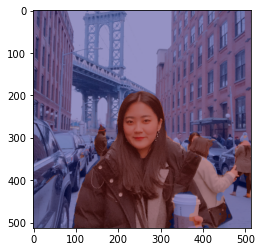

In [10]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 셸로우 포커스 만들기 - 세그멘테이션 결과를 원래 크기로 복원하기

DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했습니다. 따라서 출력도 resize 된 입력 크기와 같게 나오게 됩니다.

세그멘테이션 결과(mask)를 원래 크기로 복원해 보겠습니다.


cv2.resize() 함수를 이용합니다.

크기를 키울 때 보간(interpolation) 을 고려해야 하는데요, cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용합니다. 

보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법입니다. 

결과적으로 img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻습니다. 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정합니다. 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법입니다.



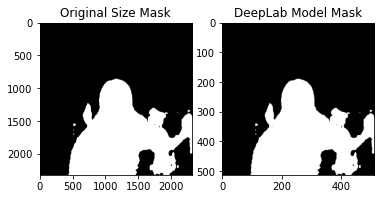

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

뒤에 있는 사람들은 깔끔하게 분리가 되지 않는 것은 볼 수 있다.
손에 들고있던 컵은 같이 분리될줄 알았는데 그러지 않았다. 


## 셸로우 포커스 만들기 -  배경 흐리게 하기
이번에는 배경을 흐리게 하기 위해서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.


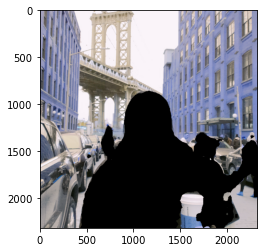

In [9]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전 함수(배경: 255, 사람 : 0)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

#### 이미지를 블러(blur)하면 배경이 흐리게 처리된 영상을 얻을 수 있습니다.

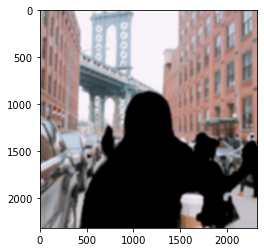

In [34]:
img_bg_blur = cv2.blur(img_bg, (30,30))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()


#### 세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 미지 값을 사용합니다.

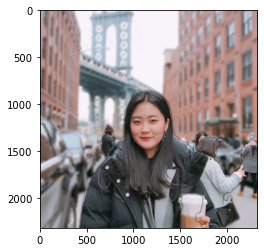

In [35]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


다른 이미지를 가져와 보겠습니다

In [16]:
#new
new_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bintan.JPG'
                                  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
new_img_orig = cv2.imread(new_img_path) 
print(new_img_orig.shape)


(3024, 3024, 3)


In [21]:
# 준비한 이미지를 네트워크에 입력한다
new_img_resized, new_seg_map = MODEL.run(new_img_orig)ew_
print (new_img_orig.shape, new_img_resized.shape, new_seg_map.max())

(3024, 3024, 3) (513, 513, 3) 15


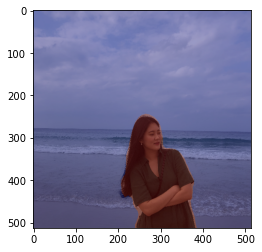

In [22]:
new_img_show = new_img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
new_img_mask = new_seg_map * (255/new_seg_map.max()) # 255 normalization
new_img_mask = new_img_mask.astype(np.uint8)
new_color_mask = cv2.applyColorMap(new_img_mask, cv2.COLORMAP_JET)
new_img_show = cv2.addWeighted(new_img_show, 0.6, new_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(new_img_show, cv2.COLOR_BGR2RGB))
plt.show()

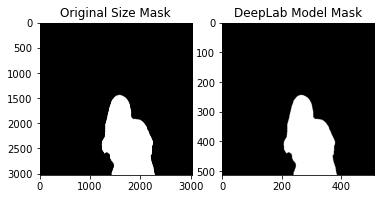

In [23]:
new_img_mask_up = cv2.resize(new_img_mask,new_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, new_img_mask_up = cv2.threshold(new_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(new_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(new_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 배경을 blur 처리 하기

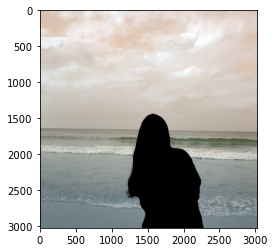

In [24]:
new_img_mask_color = cv2.cvtColor(new_img_mask_up, cv2.COLOR_GRAY2BGR)
new_img_bg_mask = cv2.bitwise_not(new_img_mask_color) # 이미지 반전 함수(배경: 255, 사람 : 0)
new_img_bg = cv2.bitwise_and(new_img_orig, new_img_bg_mask)
plt.imshow(new_img_bg)
plt.show()

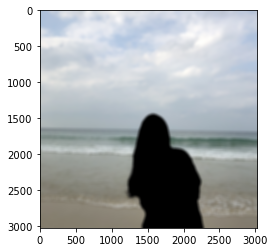

In [32]:
new_img_bg_blur = cv2.blur(new_img_bg, (50,50))
plt.imshow(cv2.cvtColor(new_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()


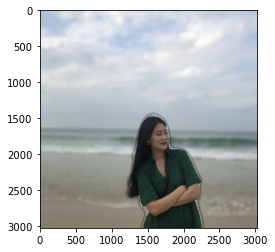

In [33]:
new_img_concat = np.where(new_img_mask_color==255, new_img_orig, new_img_bg_blur)
plt.imshow(cv2.cvtColor(new_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

blur 처리의 강도를 좀더 올렸더니 결과에서 저렇게 테두리가 나타났다.


새로운 배경을 가져와서 분리했던 이미지들과 합쳐보겠습니다~!

In [26]:
# 배경
background_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/jeju.jpeg'
background_img_orig = cv2.imread(background_img_path) 
print (background_img_orig.shape)

(4032, 3024, 3)


In [42]:
# 준비한 이미지를 네트워크에 입력한다
background_img_resized, background_seg_map = MODEL.run(background_img_orig)
print (background_img_orig.shape, background_img_resized.shape, background_seg_map.max())

(4032, 3024, 3) (513, 384, 3) 0


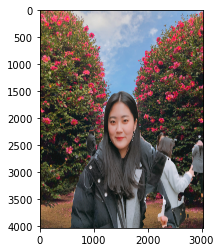

In [43]:
img_resized = cv2.resize(
    img_orig, (background_img_orig.shape[1], background_img_orig.shape[0]))
img_mask_resized = cv2.resize(
    img_mask_color, (background_img_orig.shape[1], background_img_orig.shape[0]))

img_background_concat = np.where(
    img_mask_resized == 255, img_resized, background_img_orig)

plt.imshow(cv2.cvtColor(img_background_concat, cv2.COLOR_BGR2RGB))
plt.show()

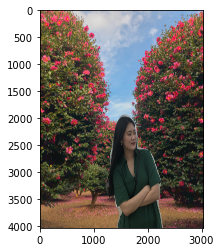

In [44]:
new_img_resized = cv2.resize(
    new_img_orig, (background_img_orig.shape[1], background_img_orig.shape[0]))
new_img_mask_resized = cv2.resize(
    new_img_mask_color, (background_img_orig.shape[1], background_img_orig.shape[0]))

new_img_background_concat = np.where(
    new_img_mask_resized == 255, new_img_resized, background_img_orig)

plt.imshow(cv2.cvtColor(new_img_background_concat, cv2.COLOR_BGR2RGB))
plt.show()

Text(0.5, 1.0, 'background')

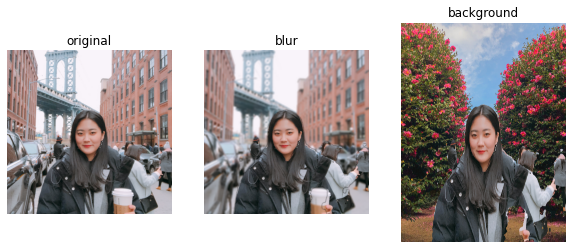

In [45]:
plt.figure(figsize=(10, 10))


plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('original')

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('blur')

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img_background_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('background')

## 단체사진을 적용해보자 




In [46]:
# three people
three_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/three.jpeg'
                                  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
three_img_orig = cv2.imread(three_img_path) 
print(three_img_orig.shape)


(3024, 4032, 3)


In [48]:
three_img_resized, three_seg_map = MODEL.run(three_img_orig)
print (three_img_orig.shape, three_img_resized.shape, three_seg_map.max())

(3024, 4032, 3) (384, 513, 3) 15


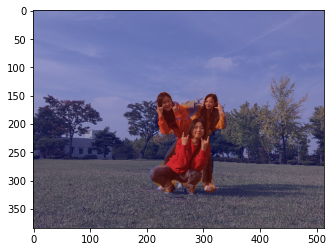

In [54]:
three_img_show = three_img_resized.copy()
three_seg_map = np.where(three_seg_map == 15, 15, 0) # 예측 중 사람만 추출
three_img_mask = three_seg_map * (255/three_seg_map.max()) # 255 normalization
three_img_mask = three_img_mask.astype(np.uint8)
three_color_mask = cv2.applyColorMap(three_img_mask, cv2.COLORMAP_JET)
three_img_show = cv2.addWeighted(three_img_show, 0.6, three_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(three_img_show, cv2.COLOR_BGR2RGB))
plt.show()

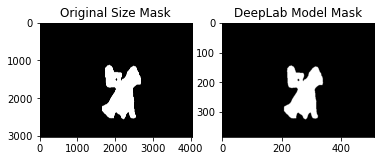

In [55]:
three_img_mask_up = cv2.resize(three_img_mask, three_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, three_img_mask_up = cv2.threshold(three_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(three_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(three_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

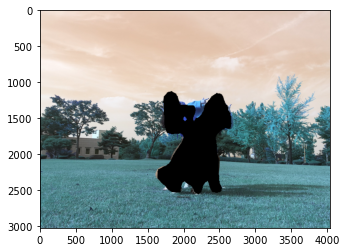

In [56]:
three_img_mask_color = cv2.cvtColor(three_img_mask_up, cv2.COLOR_GRAY2BGR)
three_img_bg_mask = cv2.bitwise_not(three_img_mask_color)
three_img_bg = cv2.bitwise_and(three_img_orig, three_img_bg_mask)
plt.imshow(three_img_bg)
plt.show()

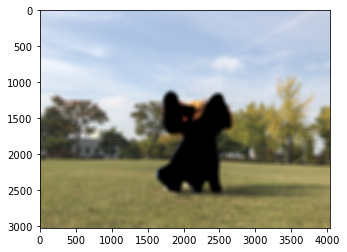

In [57]:
three_img_bg_blur = cv2.blur(three_img_bg, (70,70))
plt.imshow(cv2.cvtColor(three_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()


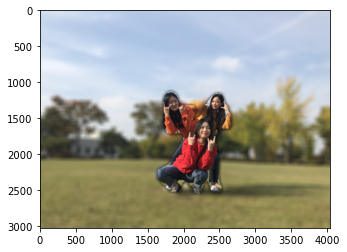

In [58]:
three_img_concat = np.where(three_img_mask_color==255, three_img_orig, three_img_bg_blur)
plt.imshow(cv2.cvtColor(three_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 시드니로 오페라하우스를 구경하러 가보겠다. 

(2048, 2048, 3)


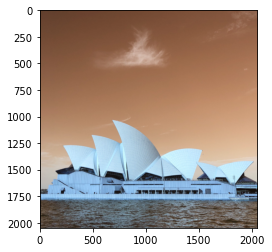

In [69]:
# 배경
background1_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/Opera.jpeg'
background1_img_orig = cv2.imread(background1_img_path) 
print (background1_img_orig.shape)
plt.imshow(background1_img_orig)

In [70]:
# 준비한 이미지를 네트워크에 입력한다
background1_img_resized, background1_seg_map = MODEL.run(background_img_orig)
print (background1_img_orig.shape, background1_img_resized.shape, background1_seg_map.max())

(2048, 2048, 3) (513, 384, 3) 0


#### 짜잔~! 눈깜짝할 사이에 오페라하우스 도착 ~

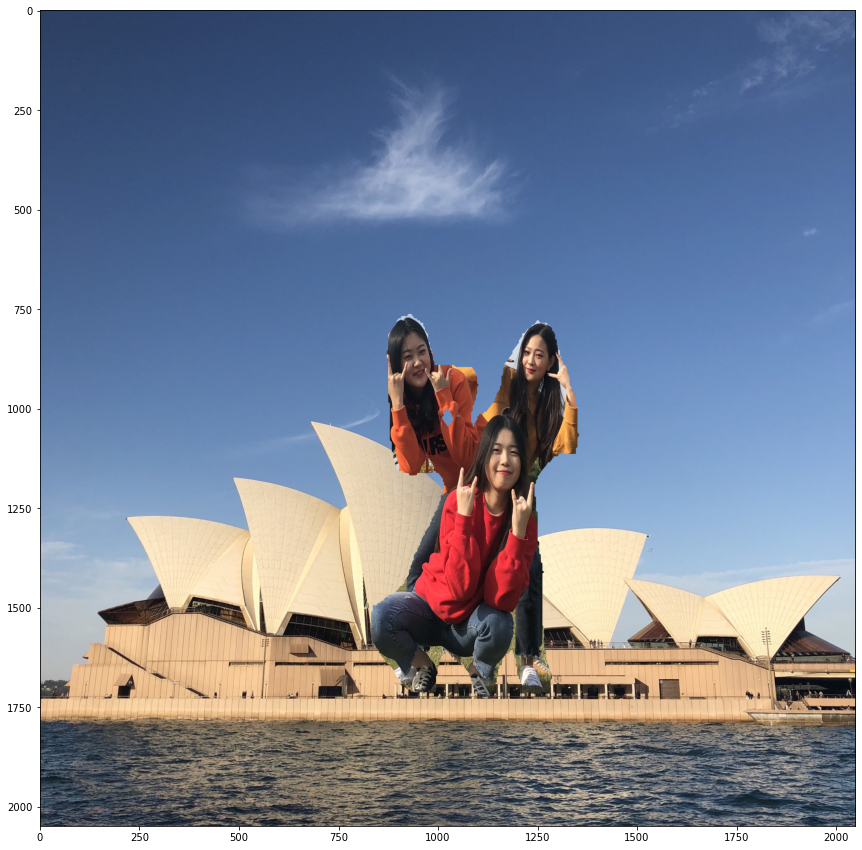

In [77]:
plt.figure(figsize=(15, 15))
three_img_resized = cv2.resize(
    three_img_orig, (background1_img_orig.shape[1], background1_img_orig.shape[0]))

three_img_mask_resized = cv2.resize(
    three_img_mask_color, (background1_img_orig.shape[1], background1_img_orig.shape[0]))

three_img_background1_concat = np.where(
    three_img_mask_resized == 255, three_img_resized, background1_img_orig)

plt.imshow(cv2.cvtColor(three_img_background1_concat, cv2.COLOR_BGR2RGB))
plt.show()


## 결과정리



### 어려움

- 문제점

이미지를 깔끔하게 분할하지 못한다(세밀한 작업은 어렵다)

blur 처리의 강도를 좀더 올렸더니 결과에서 저렇게 테두리가 나타났다.

내가 원하는 부분까지 조절을 하고싶은데 마치 포토샵을 하듯이? 그부분까지 어떻게 세세하게 할 수 있을지 궁금하다.

-> [[Segmentation] DeepLab V3 Plus](https://blog.naver.com/june093/222216258984)
image에 대해서 직접 Mask Label을 설정할 수 있다. 이런 방법으로 하면 정교하게는 가능할것 같은데... 시간은 무진장 걸리겠다. 정말 원하는 specific한 image data가 있다면 시도해야겠지만... 

- Semantic segmentation에서는 오브젝트 인스턴스끼리는 구분하지 않기 때문에 개별적으로 레이블을 각 픽셀에 붙여주어도 같은 클래스의 두개의 오브젝트가 있으면 결국 같은 카테고리의 레이블을 가질 것이다. 그래서 첫번째 사진에서 내가 뒤에 있는 사람들을 정확하게 분할 하고 싶었다면 instance segmentaion으로 같은 클래스의 인스턴스를 구분해야 했다고 생각한다.

- 또한 semantic segmentaion의 성능을 개선시키기 위해 Multi- scale inference 를 사용한다. 









### 느낀점

- 아이폰에서 어느날 새로 나온 인물사진 기능을 이용해서 사진을 많이 남겼었는데 인물모드에 대해 이렇게 직접 노드를 진행해보니 새로웠다. 

- 자연스러운 이미지를 만들어 보고싶다. 블러, 포커싱 기능 말고 다른 기능들도 있는지 찾아봐야겠다.

- 이미지 세그멘테이션이 좀더 활발하게 활용 될 만한 분야를 찾아보다가 의료 이미지 분야를 알게 되었다. 
[Anatomy-Regularized Representation Learning  for Cross-Modality Medical Image Segmentation
](https://blog.naver.com/dmswlskim/222181885138) 여기 페이지에서는 GAN과 Segmentation 활용

- 빠르고 정확한 판독이 필요한 의료분야에서 이러한 기술을 활용해서 픽셀단위로 영상을 인식하고 CT영상을 판독할 수 있는 데이터를 학습시키면 AI가 의료 분야에서 확실히 큰 기여를 할 것이라고 생각을 했다. 


- 이미지 세그멘테이션에 대해 파고들수록 점점 너무 양이 방대해져서 일단 대략적인 부분에 대해서 찾아보았다. 이번 노드에서의 문제점을 발견하고 다른 여러 방법들을 찾아보면서 흥미로웠다. 




### 더 알아봅시다 ~!

Segmentation : 사전적 의미로는 분할 

그렇다면 우리가 이번 노드에서 진행한 "분할"에 대한 작업의미는 입력(Input)된 이미지의 공간영역, 객체 등을 픽셀 수준에서 분할해서 라벨을 지정하는 작업을 했다.

예를들어 입력이미지 : 나(사람)
       출력 : 사람 = 0, 주변환경 = 1
       
라벨을 지정한다는 의미는 크게 3종류로 나눌 수 있다.

1. Semantic Segmentation
: 이미지의 모든픽셀을 특정 클래스(Class) 로 분류


2. Instance Segmentation
: 물체마다 공간을 분할하고 물체의 유형을 인식한다.


3. Panoptic Segmentaion
: Instance를 결합한 것

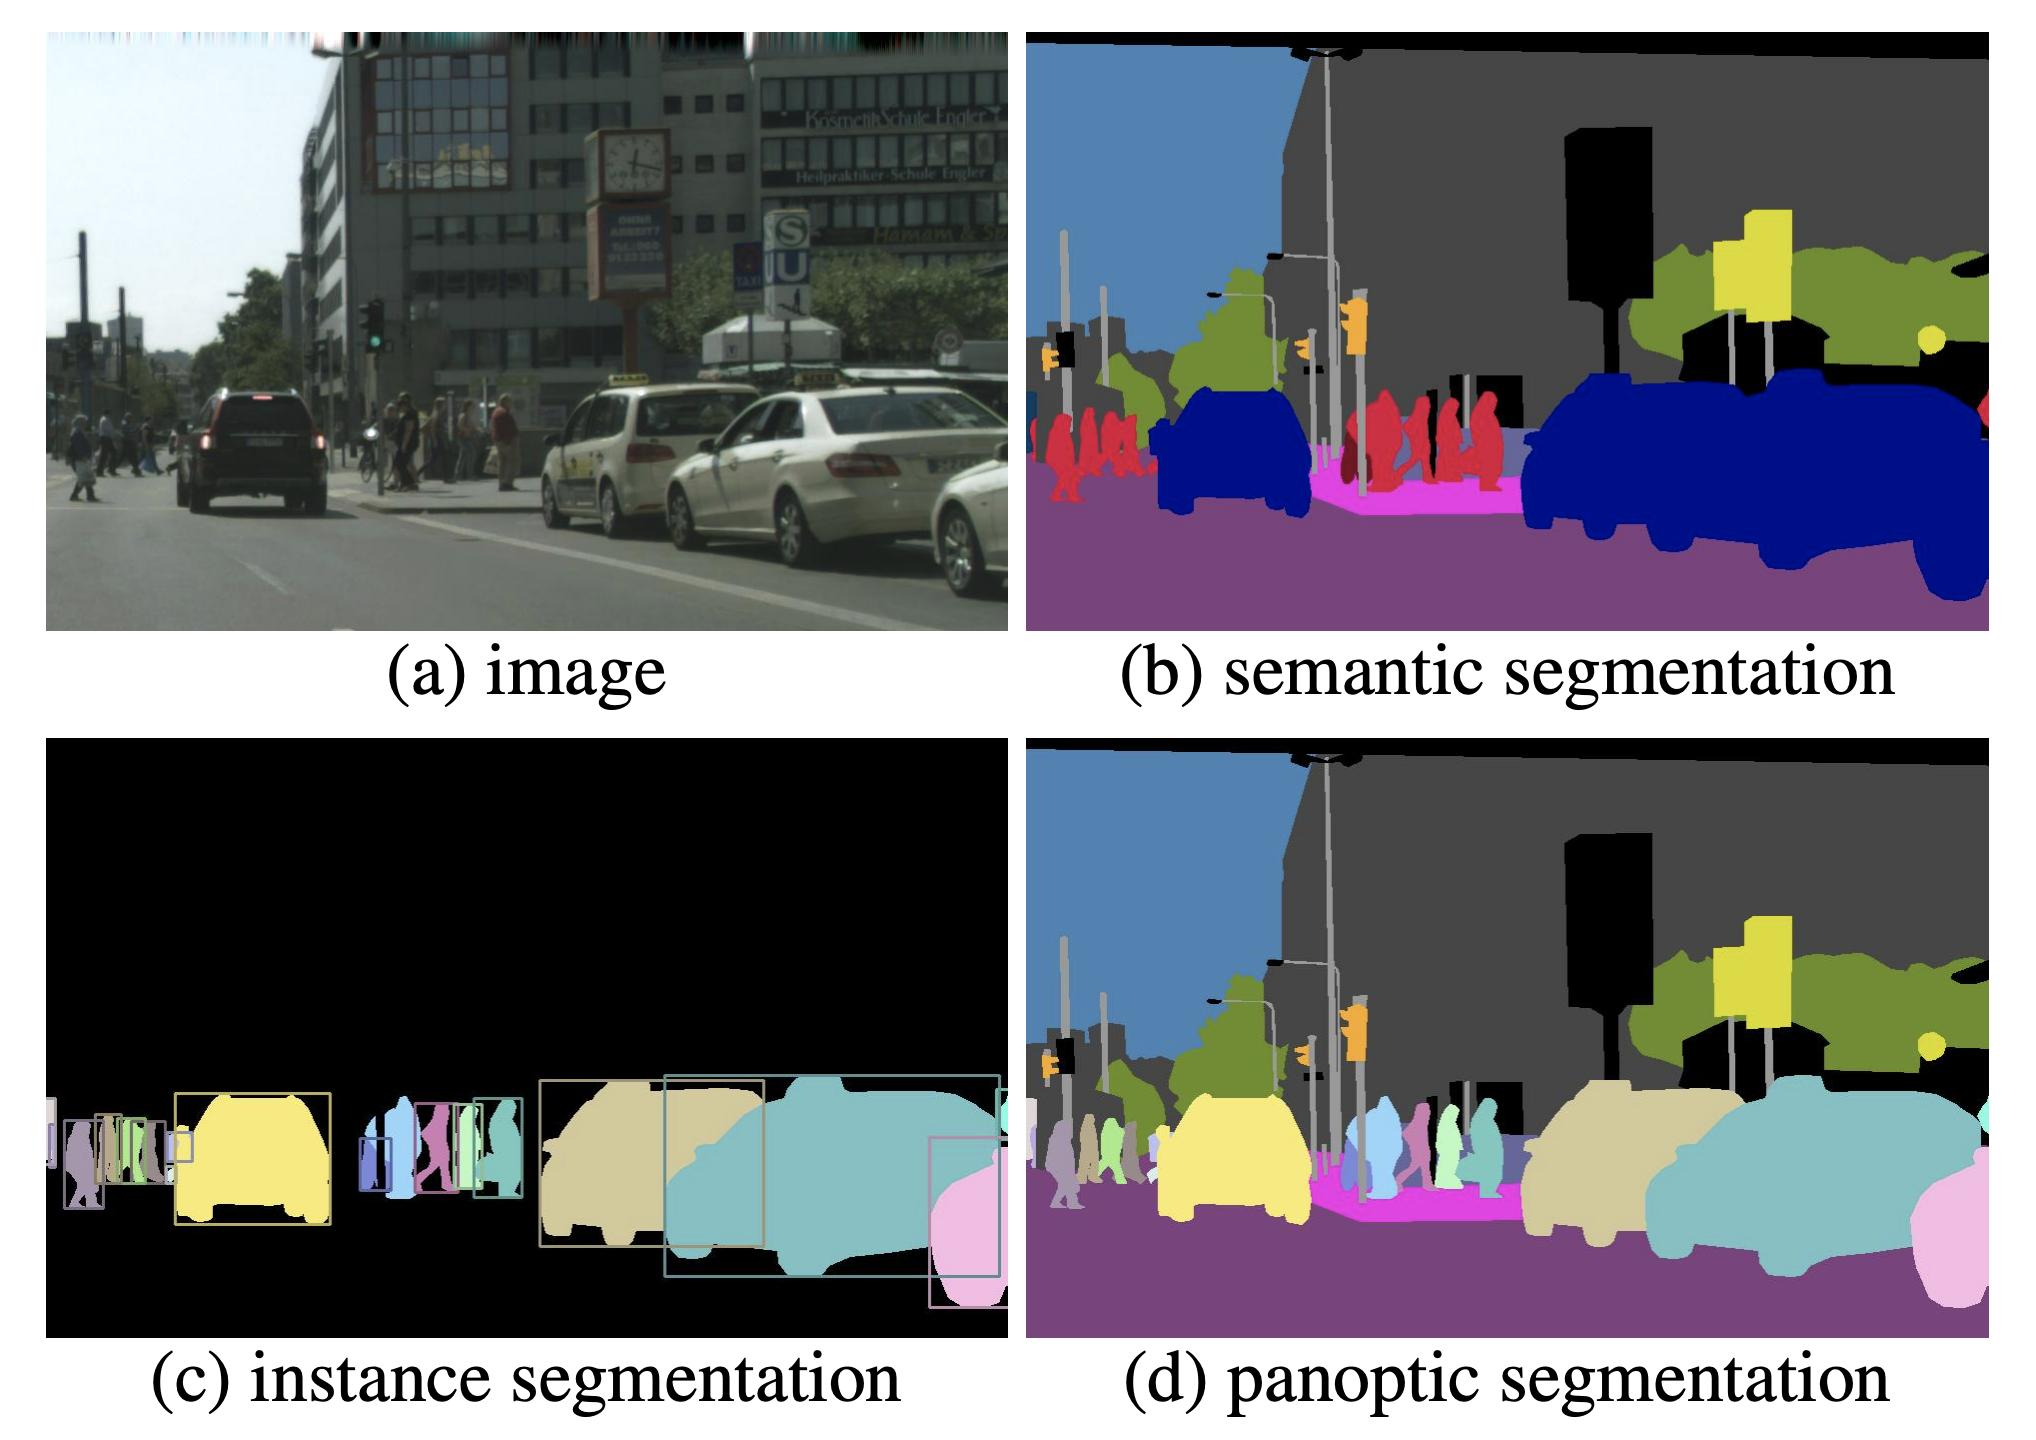





또한 Semantic Segmentaition은 예측의 특정 타입에 대해 trade-off가 발생하는데 해상도가 낮은 추론에서 잘 되는것과 고해상도에서 잘되는것이 있다고한다. 세부적인 디테일의 경우 이미지 사이즈를 키우는 것이 더 잘 예측이 되고 큰 구조들을 예측하는 것은 이미지의 사이즈를 작게하는 것이 네트워크의 receptive field가 필요한 컨텍스트를 더 많이 관찰 할 수 있기 때문이다. 이러한 문제를 class confusion이라고 한다.



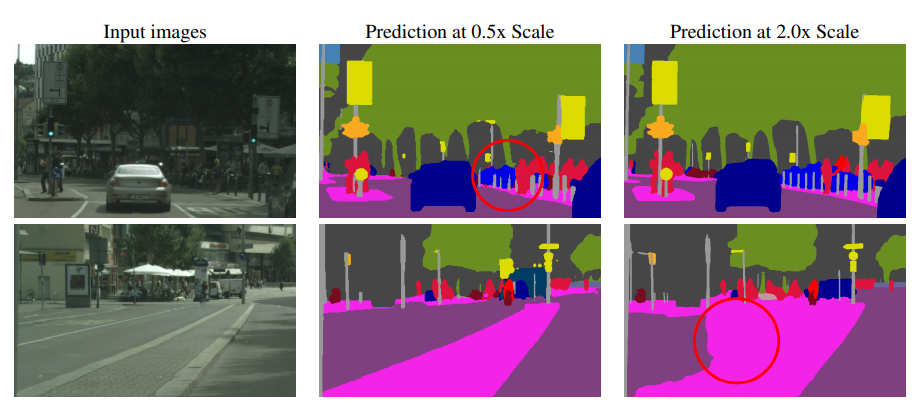



### DeepLab 

 - DeepLab V1 : Atrous convolution을 처음 적용

 - DeepLab V2 : multi-scale context를 적용하기 위한 Atrous Spatial Pyramid Pooling (ASPP) 기법을 제안

 - DeepLab V3 : 기존 ResNet 구조에 Atrous Convolution을 활용해 좀 더 Dense한 feature map을 얻는 방법을 제안

 - DeepLab V3+ : Depthwise Separable Convolution과 Atrous Convolution을 결합한 Atrous Separable Convolution의 활용을 제안

### 참고

https://blog.naver.com/ungen0630/222111148376

[Hierarchical multi-scale attention for semantic segmentaion](https://whereisend.tistory.com/232)

[이미지 세그멘테이션](https://blog.naver.com/chrhdhkd/222013933906)

[[Semantic Segmentation] DeepLab v3+ 원리](https://kuklife.tistory.com/121?category=872135)